### Face Mask Detector

Face mask detection is a two-step process - first detect faces, then detect if the face is wearing a mask correctly, incorrectly, or not at all.

This notebook contains the code for the second step in this process. Here I use MobileNet as the base model and train a custom head layer that will separate faces into one of three classes: no mask, mask worn incorrectly, and with mask.

I have followed a similar structure to this [source code](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/), further tuned and adapted to include 3 classes and to better suit the dataset.

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import os
import glob
import cv2

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# create file paths for easy reference
image_path = pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/images')
annot_path = pathlib.Path('/Users/claireph/DSI/Submissions/projects/capstone/data/annotations/')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
label_directories = sorted(glob.glob(os.path.join(annot_path, "*.xml")))

In [3]:
df = pd.read_pickle('image_df.pkl')
df.head()

,image,Dimensions,face_count,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,maksssksksss0.png,"[512, 366]",3,"[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,maksssksksss1.png,"[400, 156]",9,"[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]",...,0,0,0,0,0,0,0,0,0,0
2,maksssksksss10.png,"[301, 400]",1,"[with_mask, 98, 267, 194, 383]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,maksssksksss100.png,"[400, 226]",3,"[with_mask, 189, 30, 245, 88]","[with_mask, 387, 54, 400, 75]","[with_mask, 118, 87, 163, 126]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,maksssksksss101.png,"[301, 400]",1,"[with_mask, 48, 294, 164, 400]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Prep Images for Face Mask Detection Model

To train this model, the first step is to isolate all of the faces in each image and resize them for the model. To do this, we will look through all objects in the dataframe, using the bounding box dimensions to extract faces. Experimentation with various minimum facial dimensions made clear that a 15x15 pixel slice is ideal for the mask training model. The next step is to resize the faces to 224x224, which our model requires for input. Finally, the faces are preprocessed as required for the MobilenetV2 model. The preprocessing step scales all pixels to be between -1 and 1 sample-wise.

In [4]:
classes = ["without_mask","mask_weared_incorrect","with_mask"]
labels = []
data = []

# Extract data into respective label folders
for idx,image in enumerate(image_directories):
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            # first element of the "object" cell - replace label with the index from classes list
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            # Set a minimum size of 15 x 15 for face detection to improve model performance
            if((info[3]-info[1]>15) and (info[4]-info[2])>15):
                try:
                    face = cv2.resize(face, (224, 224))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    data.append(face)
                    labels.append(label)

                except:
                    pass

print("Done!")

Done!


In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
labels[:10]

array(['without_mask', 'with_mask', 'without_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask'], dtype='<U21')

In [6]:
# Check label counts after limiting data to bounding boxes with > 15x15 dims:
label_dict = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}

for i in labels:
    label_dict[i] += 1

print("Total faces for model: ", len(labels))
print("Faces with mask: ", label_dict['with_mask'])
print("Faces without mask: ", label_dict['without_mask'])
print("Faces with mask worn incorrectly: ", label_dict['mask_weared_incorrect'])

Total faces for model:  2800
Faces with mask:  2287
Faces without mask:  418
Faces with mask worn incorrectly:  95


In [7]:
# Determine a baseline model
baseline = 2394 / 2936
baseline

0.8153950953678474

### Prep for Modeling


Now that our data and labels have been extracted, resized, and preprocessed, there are a few additional steps that need to be taken before modeling. This includes:
- encoding labels
- train/test/splitting the data
- creating guidelines for image augmentation

The ImageDataGenerator allows us to randomly rotate, zoom, shift, shear, and flip each image - this leads to a more robust model that is less prone to overfitting.

In [8]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [9]:
lb.classes_

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype='<U21')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.30,
                                                   stratify=labels, random_state = 22)

In [25]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Model

MobileNetV2 is used as the base model. Model is loaded with pre-trained imagenet weights - allowing for transfer learning! This will be especially helpful for our smaller dataset. More can be learned about the MobileNetV2 model [here.](https://arxiv.org/pdf/1801.04381.pdf)  

The top of the model is not included so that a custom head layer can be built on top.

In [26]:
# Set initial parameters
INIT_LR = .0005
EPOCHS = 50
BS = 96

In [27]:
# load base model with imagenet pre-trained weights
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [28]:
# build top layer
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [29]:
# combine base model and head model layers, this will be the model used for training
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze base model layers so that they will not be updated during the training process. 
# This way, only the head layers are adjusted during back propogation.
for layer in baseModel.layers:
    layer.trainable = False

In [30]:
import tensorboard
import datetime
%reload_ext tensorboard
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [31]:
# add callbacks - one for early stopping, and one that will create a tensorboard for evaluation
callback1 = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS,
    callbacks=[callback1, callback2])

Epoch 1/50
20/20 [==============================] - 65s 3s/step - loss: 0.5810 - accuracy: 0.8149 - val_loss: 0.3456 - val_accuracy: 0.8905
Epoch 2/50
20/20 [==============================] - 57s 3s/step - loss: 0.3797 - accuracy: 0.8702 - val_loss: 0.3002 - val_accuracy: 0.9131
Epoch 3/50
20/20 [==============================] - 52s 3s/step - loss: 0.3377 - accuracy: 0.8841 - val_loss: 0.2848 - val_accuracy: 0.9036
Epoch 4/50
20/20 [==============================] - 50s 3s/step - loss: 0.3179 - accuracy: 0.8922 - val_loss: 0.2718 - val_accuracy: 0.9167
Epoch 5/50
20/20 [==============================] - 50s 3s/step - loss: 0.3005 - accuracy: 0.8948 - val_loss: 0.2477 - val_accuracy: 0.9155
Epoch 6/50
20/20 [==============================] - 54s 3s/step - loss: 0.2783 - accuracy: 0.9029 - val_loss: 0.2440 - val_accuracy: 0.9155
Epoch 7/50
20/20 [==============================] - 56s 3s/step - loss: 0.2790 - accuracy: 0.9120 - val_loss: 0.2410 - val_accuracy: 0.9179
Epoch 8/50
20/20 [==

In [19]:
# Model summary is quite long and includes all 17 blocks from MobileNetV2 - un-comment below if you want to dig deeper!
# model.summary()

### Model Metrics

Training and validation accuracy were very closely tied - after training, accuracy score of 93.6% on the training data, and 94.2% on validation data. Categorical cross-entropy was used to measure loss, also very close for both train and validation - about 0.19.


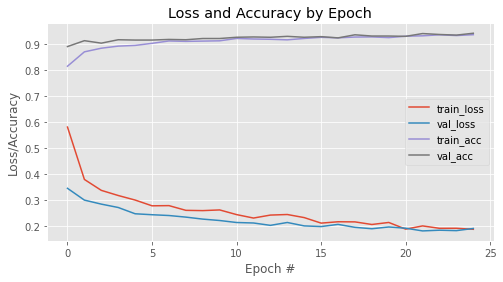

In [36]:
# plot the training loss and accuracy
N = len(history.epoch)
plt.style.use("ggplot")
plt.figure(figsize = (8, 4))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Loss and Accuracy by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best");

### Model Predictions

Now that we have a trained model it is time to build predictions. Here the challenge of imbalanced classes is apparent: the Precision on "Mask Weared Incorrect" is 100%, but recall is only 0.21. The metrics, along with the confusion matrix show that this model is very good at correctly predicting the "With Mask" and "Without Mask" categories.

In [33]:
# make predictions on the testing set
predIdxs = model.predict(X_test, batch_size=BS)

# find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(y_test.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

                       precision    recall  f1-score   support

mask_weared_incorrect       1.00      0.21      0.34        29
            with_mask       0.94      0.99      0.97       686
         without_mask       0.92      0.84      0.88       125

             accuracy                           0.94       840
            macro avg       0.96      0.68      0.73       840
         weighted avg       0.94      0.94      0.93       840



In [34]:
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)

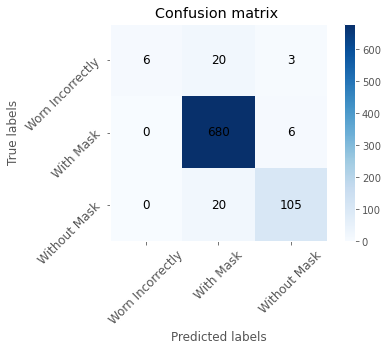

In [35]:
# Aid from: https://stackoverflow.com/questions/51282098/plotting-confusion-matrix-for-an-image-classification-model
plt.style.use("ggplot")
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
plt.yticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
plt.title('Confusion matrix ')
plt.grid(None)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', size='large')
plt.show()

In [37]:
# Run a TensorBoard if we're feeling fancy!
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 23689), started 4 days, 3:05:09 ago. (Use '!kill 23689' to kill it.)

### Save Model

Now that we have a saved face mask detector model, we can experiment with how this model performs on various face detectors. In the following notebooks, this model will make predictions based on faces detected using OpenCV DNN and MTCNN. This model can also be loaded into a .py script to be used for video detection.

In [38]:
# Save model
model.save('face_mask_detector.h5')